## CDS503 Machine Learning Project
## Project Title: Spanish High Speed Train Price Ticket Prediction 
 Name: Shang Ming Xia (P-COM0077/19), Ling Hui Ting (P-COM0086/19), Lim Sheau Yee (P-COM0131/19) 

## Data Preparation

In [1]:
# Import the standard modules to be used in this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMRegressor


In [2]:
# Import Data and defined classifier
precisions=[]
predict=[]
y_tests=[]
data = pd.read_csv('renfe.csv')
lg = LGBMRegressor(n_estimators=1000)
knn = KNeighborsClassifier()
gnb = GaussianNB()
regression = LinearRegression()
classifiers = [regression,lg,knn,gnb]
classifier_names = ['Regression','LGB','KNN','Bayes']

In [44]:
#Check the size of dataset
data.shape

(7671354, 9)

In [45]:
#Check the types of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7671354 entries, 0 to 7671353
Data columns (total 9 columns):
insert_date    object
origin         object
destination    object
start_date     object
end_date       object
train_type     object
price          float64
train_class    object
fare           object
dtypes: float64(1), object(8)
memory usage: 526.8+ MB


In [46]:
#Check the missing values
data.isnull().any()

insert_date    False
origin         False
destination    False
start_date     False
end_date       False
train_type     False
price           True
train_class     True
fare            True
dtype: bool

In [47]:
nan_lines = data.isnull().any(1)

In [48]:
#Check the size of the missing value 
nan_lines.sum()

573121

In [3]:
#Drop the missing value
data=data.dropna(how='any')

In [72]:
#Check outliers and irrelavant data 
print(f"Min price is at Euro {data.price.min()}")
print(f"Max price is at Euro {data.price.max()}")

print(f"start_date minimum is {data.start_date.min()}")
print(f"start_date maximum is {data.start_date.max()}")

print(f"end_date minimum is {data.end_date.min()}")
print(f"end_date maximum is {data.end_date.max()}")

Min price is at Euro 0.0
Max price is at Euro 342.8
start_date minimum is 2019-04-12 05:50:00
start_date maximum is 2019-10-20 22:14:00
end_date minimum is 2019-04-12 08:38:00
end_date maximum is 2019-10-21 04:31:00


In [4]:
#Drop the irrelavant data
data = data[data.price != 0]
data.shape

(7098182, 9)

## Data Exploration

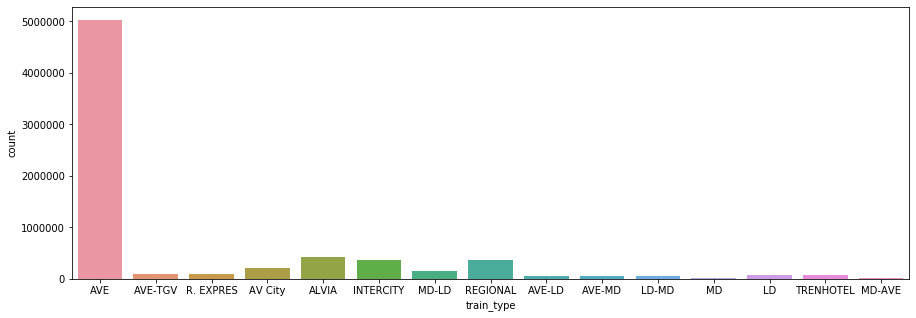

In [94]:
#Types of Train in Spain
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(data['train_type'])

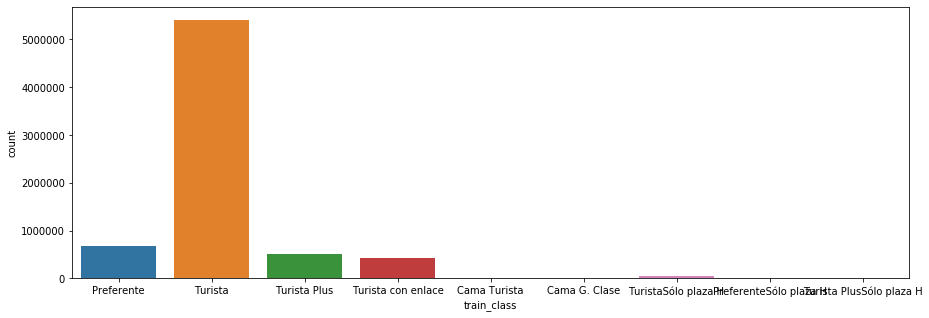

In [95]:
#Types of train class
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(data['train_class'])

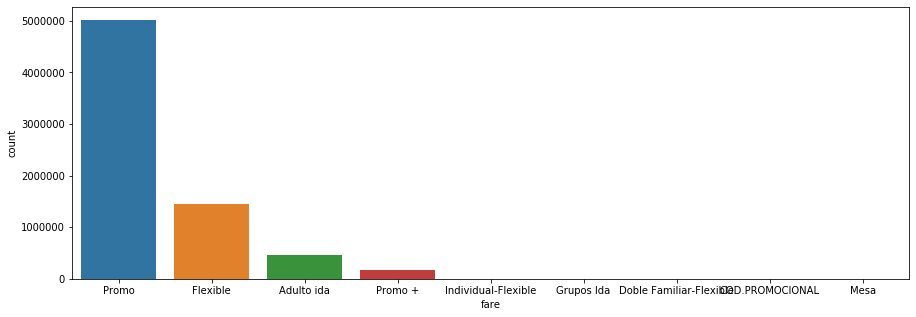

In [97]:
#Types of fare
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(data['fare'])

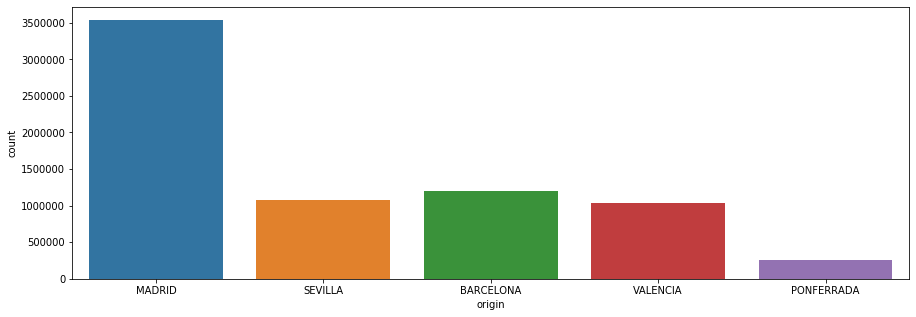

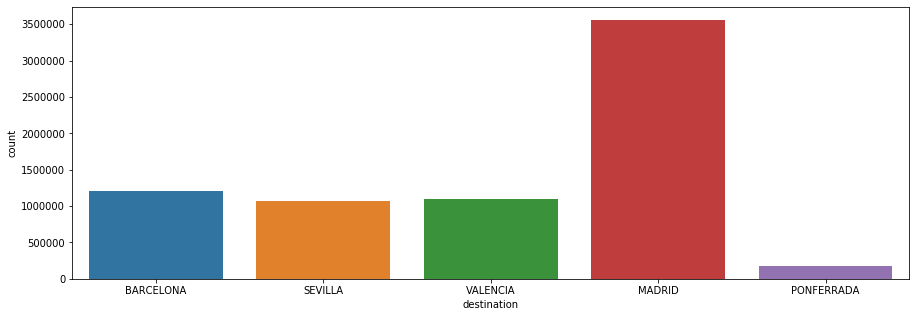

In [98]:
# Number of passenger boarding and get down at different station
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(data['origin'])

fig,ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(data['destination'])

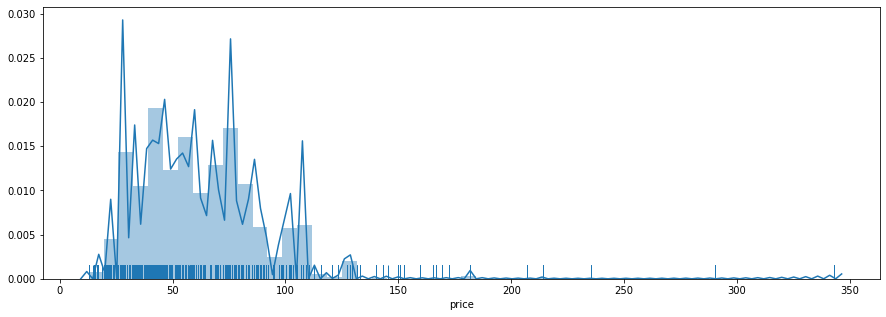

In [18]:
#Distribution of the ticket price
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.distplot(data['price'],rug=True)

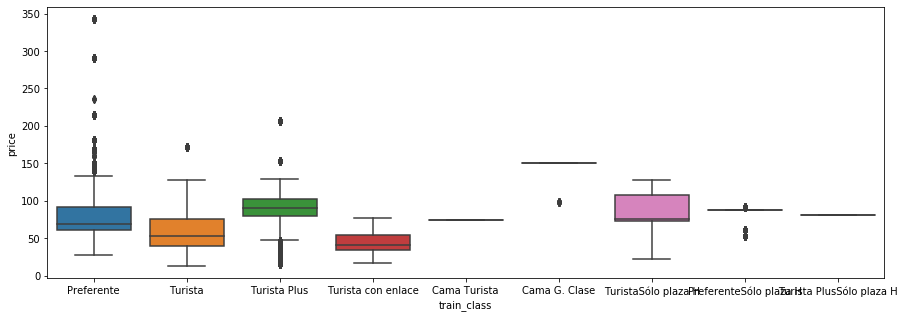

In [99]:
#Train_class vs price
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.boxplot(x='train_class',y='price',data=data)

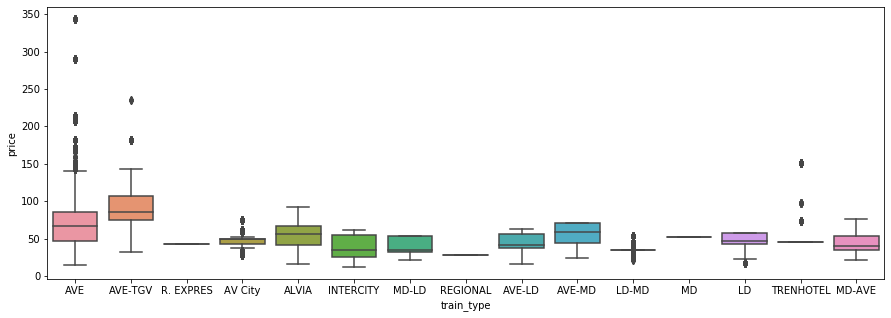

In [100]:
#Train_type vs price
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.boxplot(x='train_type',y='price',data=data)

## Feature Engineering

In [5]:
#Converting datetime
for i in ['insert_date','start_date','end_date']:
    data[i] = pd.to_datetime(data[i])

In [6]:
#Label Encoding
lab_en = LabelEncoder()
data.iloc[:,0] = lab_en.fit_transform(data.iloc[:,0])
data.iloc[:,1] = lab_en.fit_transform(data.iloc[:,1])
data.iloc[:,2] = lab_en.fit_transform(data.iloc[:,2])
data.iloc[:,3] = lab_en.fit_transform(data.iloc[:,3])
data.iloc[:,4] = lab_en.fit_transform(data.iloc[:,4])
data.iloc[:,5] = lab_en.fit_transform(data.iloc[:,5])
data.iloc[:,6] = lab_en.fit_transform(data.iloc[:,6])
data.iloc[:,7] = lab_en.fit_transform(data.iloc[:,7])
data.iloc[:,8] = lab_en.fit_transform(data.iloc[:,8])

In [108]:
data.head(10)

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,0,1,0,472,604,2,224,2,7
1,0,1,0,475,607,2,243,4,7
2,0,1,0,477,608,2,299,5,7
3,0,1,0,482,621,2,276,5,7
4,0,1,0,484,618,2,271,4,7
5,0,1,0,486,623,2,300,4,3
6,0,1,0,492,633,2,300,4,3
7,0,1,0,497,637,2,294,5,7
8,0,1,0,503,648,2,294,5,7
9,0,1,0,509,653,2,300,4,3


In [7]:
#Define x and y 
x=data.drop(columns=['price'],axis=1)
y=data['price']

In [10]:
#Find the correlation
corr_matrix = data.corr() 
corr_matrix['price'].sort_values(ascending=True)

origin        -0.450708
train_type    -0.435272
destination   -0.413326
end_date      -0.178518
start_date    -0.178055
train_class   -0.143754
insert_date   -0.092467
fare           0.013249
price          1.000000
Name: price, dtype: float64

In [8]:
#Splitting train test set data
x_train, x_test, y_train, y_test = train_test_split(x,y)

In [9]:
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

x_train = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train)

x_test = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test)

## regression_model

In [10]:
regression.fit(x_train, y_train)
precision=regression.score(x_test,y_test)
precisions.append(precision)
precision

0.6948727886018404

### lgb

In [11]:
lg.fit(x_train,y_train)
precision=lg.score(x_test,y_test)
precisions.append(precision)
precisions

## evalution_regression

In [13]:
y_pred=regression.predict(x_test)
predict.append(y_pred)
y_tests.append(y_test)

In [14]:
precisions

[0.6948727886018404, 0.9176722124161668]

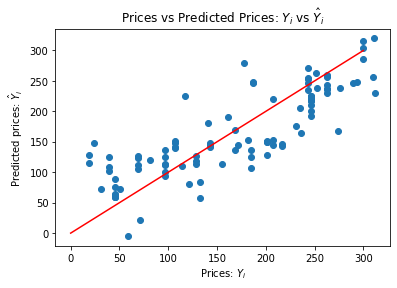

In [115]:
plt.scatter(y_test[0:100], y_pred[0:100])
plt.xlabel('Prices: $Y_i$')
plt.ylabel('Predicted prices: $\hat{Y}_i$')
plt.title('Prices vs Predicted Prices: $Y_i$ vs $\hat{Y}_i$')
# plot a line, a perfect prediction would all fall on this line 
x = np.linspace(0, 300, 600)
y=x
plt.plot(x, y, 'r')

In [17]:
from sklearn.metrics import mean_absolute_error 
print(mean_absolute_error(y_test, y_pred))

37.12991204025812


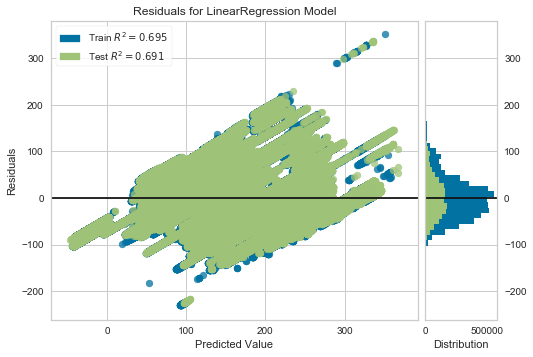

In [18]:
from yellowbrick.regressor import ResidualsPlot 
res_plot = ResidualsPlot(regression) 
res_plot.fit(x_train, y_train) 
res_plot.score(x_test, y_test)
res_plot.poof()

## evalution_LGB

In [15]:
y_pred=lg.predict(x_test)
predict.append(y_pred)
y_tests.append(y_test)

In [21]:
from sklearn.metrics import mean_absolute_error 
print(mean_absolute_error(y_test, y_pred))

15.099369934958291


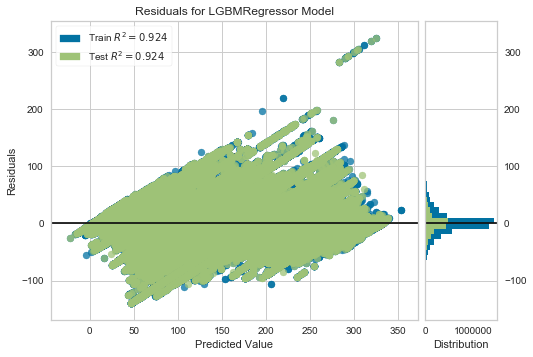

In [23]:
from yellowbrick.regressor import ResidualsPlot 
res_plot = ResidualsPlot(lg) 
res_plot.fit(x_train, y_train) 
res_plot.score(x_test, y_test)
res_plot.poof()

## KNN

In [16]:
y = data['price']
x = data.drop(columns=['price'],axis=1)
y_cls=y//30
y_cls

0           7
1           8
2           9
3           9
4           9
5          10
6          10
7           9
8           9
9          10
10         10
11          9
12         10
14          9
15          8
16          9
17         10
18          8
19          8
21          7
22          8
23          8
24          8
25          8
26          8
27          8
28          8
29          8
30          8
31          8
           ..
7671324     7
7671325     4
7671326     1
7671327     0
7671328     1
7671329     2
7671330     1
7671331     6
7671332     6
7671333     4
7671334     3
7671335     1
7671336     6
7671337     6
7671338     5
7671339     3
7671340     5
7671341     1
7671342     1
7671343     3
7671344     1
7671345     2
7671346     1
7671347     2
7671348     3
7671349     1
7671350     2
7671351     4
7671352     0
7671353     4
Name: price, Length: 7098182, dtype: int64

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x,y_cls)

In [18]:
knn.fit(x_train,y_train)
# Print results
y_pred=knn.predict(x_test)
predict.append(y_pred)
y_tests.append(y_test)
precision=knn.score(x_test,y_test)
print("performance {:05.2f}%" .format(precision*100 ))
precisions.append(precision)

performance 32.88%


In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.39      0.29     53009
           1       0.32      0.35      0.34    167726
           2       0.19      0.16      0.18    114496
           3       0.25      0.23      0.24    160599
           4       0.29      0.29      0.29    164296
           5       0.23      0.20      0.22    169210
           6       0.23      0.20      0.21    190640
           7       0.29      0.27      0.28    181989
           8       0.45      0.57      0.50    300820
           9       0.38      0.32      0.35    160913
          10       0.51      0.45      0.48    110041
          11       0.00      0.00      0.00       820

    accuracy                           0.32   1774559
   macro avg       0.28      0.29      0.28   1774559
weighted avg       0.32      0.32      0.32   1774559



In [19]:
gnb.fit(x_train,y_train)
y_pred=gnb.predict(x_test)
# Print results
predict.append(y_pred)
y_tests.append(y_test)
precision=gnb.score(x_test,y_test)
print("performance {:05.2f}%" .format(precision*100 ))
precisions.append(precision)

performance 22.82%


In [20]:
print(classification_report(y_test, y_pred))

/Users/mac/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.08      0.14      0.10     53009
           1       0.59      0.57      0.58    167726
           2       0.00      0.00      0.00    114496
           3       0.08      0.07      0.08    160599
           4       0.11      0.05      0.07    164296
           5       0.20      0.01      0.01    169210
           6       0.00      0.00      0.00    190640
           7       0.00      0.00      0.00    181989
           8       0.21      0.88      0.33    300820
           9       0.00      0.00      0.00    160913
          10       0.00      0.00      0.00    110041
          11       0.00      0.00      0.00       820

    accuracy                           0.22   1774559
   macro avg       0.11      0.14      0.10   1774559
weighted avg       0.13      0.22      0.13   1774559



In [20]:
precisions

[0.6948727886018404,
 0.9176722124161668,
 0.32876352599481784,
 0.2281704728984202]

## comparison

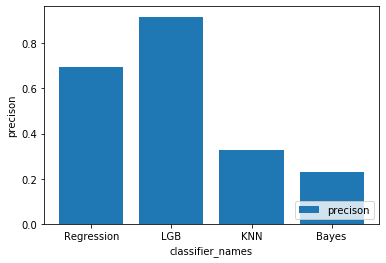

In [21]:
plt.bar(classifier_names, precisions, label='precison')
plt.xlabel("classifier_names")
plt.ylabel('precison')
plt.legend(loc=4)
plt.show()